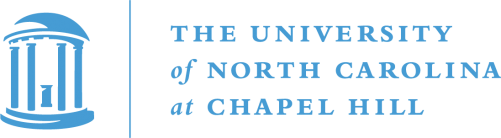


# Notebook 11
**Course:** *Econ 590, Computational Methods for Economists*, [University of North Carolina at Chapel Hill](https://econ.unc.edu/), Spring 2025  
**Instructor:** [Marlon Azinovic-Yang](https://sites.google.com/view/marlonazinovic/home)  
**Contact:** marlonay@unc.edu  
**References:** This notebook has benefited greatly from the teaching material and notebooks generously made available by [Simon Scheidegger](https://sites.google.com/site/simonscheidegger/home), [Felix Kubler](https://sites.google.com/site/fkubler/), [Harold Linh Cole](https://economics.sas.upenn.edu/people/harold-l-cole), [Jeremy Greenwood](https://www.jeremygreenwood.net/), [Jeppe Druedahl](https://sites.google.com/view/jeppe-druedahl/), [Rick Evans](https://sites.google.com/site/rickecon/), and by [Tom Sargent](http://www.tomsargent.com/) and [John Stachurski](https://johnstachurski.net/) on [QuantEcon](https://quantecon.org/).

# Content
The goal of this notebook we solve the Ramsey model allowing for continuous values of capital by using cubic spline interpolation to approximate the value function. 

In [34]:
import numpy as np # for vectors and arrays
import matplotlib.pyplot as plt # for plotting
from scipy.interpolate import interp1d # for interpolating
from scipy.optimize import minimize

Parameters and steady state capital
We first set the parameter values for the parameters we will keep fixed throughout the problem and then we compute the steady state level of capital. The steady state level of capital, $K_{ss}$, has the property that, if we are at the steady state level of capital in period $t$, i.e. $K_t = K_{ss}$, the representative agent will optimally choose the same capital level for the next period, i.e. $K_{t+1} = K_{ss}$. This implies that, once the economy reaches the steady state level of capital, it will remain at that capital level forever.

In [35]:
beta = 0.9 # patience
alpha = 0.3 # capital share in production
delta = 0.1 # depreciation rate of capital
gamma = 2.0 # coefficient of relative risk aversion

For later use we can define a function that maps consumption to the corresponding utility. The utility function is defined to be $u(C) = \frac{C^{1 - \gamma}}{1 - \gamma}$.

In [36]:
def utility(C):
    """
    Function computes and returns the utility from consumption C
    using the globally defined parameter as coefficient of relative risk aversion
    """
    u = C ** (1. - gamma) / (1 - gamma)
    return u

We now compute the implied steady state level of capital, which is given by $K_{ss} = \left( \frac{\frac{1}{\beta} + \delta - 1}{\alpha} \right) ^ {\frac{1}{\alpha - 1}}$.

In [37]:
Kss = ((1 / beta + delta - 1) / alpha) ** (1 / (alpha - 1))
print("The steady state level of capital is given by ", Kss)

The steady state level of capital is given by  1.652017025761955


## Choosing the interpolation nodes and initializing the functions

The state of the economy is given by the level of capital $K$ and the policy, i.e. the action the household has to decide on, is how much capital $K'$ to save for the next period, given the current level of capital $K$. Therefore the value function $V(K)$ as well as the policy function $\pi(K) = K'$ are functions of the capital level $K$. Our goal is two compute these two functions. To do so we approximate the policy and value functions using cubic spline interpolation between equally spaced interpolation nodes for capital.

In [57]:
nK = 50 # choose the number interpolation nodes


Kgrid = np.linspace(0.10, 2.99, nK) * Kss # create an equally grid of values between 1% and 200% of the steady state level of capital
print("Kgrid = ", Kgrid)

# intialize value for the policy and value function we assume that the vlaue is 0 and the policy is to save the lowest level in our intveral
Vgrid = np.zeros(nK)
Knextgrid = np.ones(nK) * Kgrid[0]

Vapprox = interp1d(Kgrid, Vgrid, kind = "cubic", fill_value="extrapolate")
Knextapprox = interp1d(Kgrid, Knextgrid, kind = "cubic", fill_value="extrapolate")

# lets try it out
print("Vapprox(Kss) = ", Vapprox(Kss))
print("Knextapprox(Kss) = ", Knextapprox(Kss))




Kgrid =  [0.1652017  0.26263699 0.36007228 0.45750757 0.55494286 0.65237815
 0.74981344 0.84724873 0.94468402 1.04211931 1.1395546  1.23698989
 1.33442518 1.43186047 1.52929576 1.62673105 1.72416634 1.82160163
 1.91903692 2.01647221 2.1139075  2.21134279 2.30877808 2.40621337
 2.50364866 2.60108395 2.69851924 2.79595453 2.89338982 2.99082511
 3.0882604  3.18569569 3.28313098 3.38056627 3.47800156 3.57543685
 3.67287214 3.77030743 3.86774272 3.96517801 4.0626133  4.16004859
 4.25748388 4.35491917 4.45235446 4.54978975 4.64722504 4.74466033
 4.84209562 4.93953091]
Vapprox(Kss) =  0.0
Knextapprox(Kss) =  0.16520170257619554


A single Bellman update
The Bellman equation we want to solve is given by
\begin{align}
V(K) &= \max_{K'} u(C) + \beta V(K') \\
\text{where}:& \nonumber \\
C &= K^\alpha + (1 - \delta) K - K'.
\end{align}
To solve this functional equation with dynamic programming, we start out with a guess $V^{\text{old}}(\cdot)$ for the value function, and then compute an updated value $V^{\text{new}}(\cdot)$ according to
\begin{align}
V^{\text{new}}(K) &= \max_{K'} u(C) + \beta V^{\text{old}}(K') \\
\text{where}:& \nonumber \\
C &= K^\alpha + (1 - \delta) K - K'.
\end{align}
This equation looks very similar to the Bellman equation, with an important difference: we have a guessed value function $V^{\text{old}}(\cdot)$ on the right hand side, and the new updated value $V^{\text{new}}(\cdot)$ on the left hand side of the equation. The last equation coincides with the Bellman equation, only if the new value function $V^{\text{new}}(\cdot)$ is equal to the guessed value function $V^{\text{old}}(\cdot)$. The basic idea of dynamic programming is to update the guess for the value function until $V^{\text{new}}(\cdot)$ and $V^{\text{old}}(\cdot)$ are equal, then we have found the solution to the Bellman equation. 

We now implement a single updating step that takes a guess for the value function $V^{\text{old}}(\cdot)$ as given and compute the updated value $V^{\text{new}}(K)$ for a specific level of capital $K$.

In [108]:
def get_update(K, Vapprox_old, alpha, beta, delta, Kgrid):
    """
    Function compute a new value Vnew(K) for a given capital level K
    assuming that the continuation value is evaluated according to the guessed
    function Vapprox_old.

    inputs:
    K:          float, level of capital
    Vapprox_old: function, that gives the value for a given level of capital
    alpha:      float, capital share in production, such that Y = K ^ alpha
    beta:       float, patience
    delta:      float, depreciation rate of capital
    Kgrid:      vector of floats, interpolation nodes for capital
    
    output:
    Vnew_K:     float, gives the updates value Vnew(K)
    Knext_K:    float, gives the updates policy pi(K) = K'
    """

    # we have to set up the objective function
    def obj_function(Knext):
        # compute the consumption if the policy would be given by Knext
        C = K ** alpha + (1 - delta) * K - Knext
        C = max(C, 1e-15)
        
        # get the continuation value using the approximate value function
        Vnextperiod = Vapprox_old(Knext)

        # get the total value
        tot_value = utility(C) + beta * Vnextperiod

        # we return the negative because python optimizers always minimize
        return (- 1) * tot_value

    # use an optimizer to find the value of Knext that maximizes the total value
    x_initial_guess = max((1 - delta) * K, Kgrid[0]) # the optimizer needs and initial guess
    lower_bound = Kgrid[0] #we provide upper and lower bounds to ensure we stay in the interval
    upper_bound = Kgrid[-1]
    sol = minimize(obj_function, x0 = x_initial_guess, bounds=[(lower_bound, upper_bound)], method = "Nelder-Mead")

    # get the value and the policy
    Vnew_K = -sol.fun
    Knext_K = sol.x[0]

    # we return the new value, new policy
    
    return Vnew_K, Knext_K

In [109]:
get_update(Kgrid[0], Vapprox, alpha, beta, delta, Kgrid)

(-14.063552665686235, 0.29439459654398603)

As we expected, if the continuation value is always zero, the household will save the lowest possible value of capital for the next  period.

Update the complete value function
The function above helps us to get the new value and new policy for a specific value of $K$. Now we want to update the whole function, meaning we need to get the new value and policy for all interpolation nodes and then update the interpolating functions.

In [110]:
def update_V(Kgrid, Vapprox, alpha, beta, delta):
    """
    Function compute an updated value function Vnew(K) and an updated 
    policy function Knext(K) for all interpolation nodes, and then updates the interpolating functions.

    inputs:
    Kgrid:      vector of nK floats, giving the interpolation nodes for the state K
    Vapprox:    function, giving the value Vold(K) 
    alpha:      float, capital share in production, such that Y = K ^ alpha
    beta:       float, patience
    delta:      float, depreciation rate of capital
    
    output:
    Vapprox:            function, updated value function
    Knextapprox:        function, updated policy function
    """
        
    nK = Kgrid.shape[0]
    
    # prepare arrays to store the updated value and policy functions
    Vnew_nodes = np.zeros(nK)
    Knext_nodes = np.zeros(nK)
    
    # use a for loop to iterate through the nK possible value of capital K
    for i in range(nK):
        # get the corresponding value of capital
        K = Kgrid[i]
        
        # update the value and policy functions for that capital level
        Vnew_update, Knext_update = get_update(K, Vapprox, alpha, beta, delta, Kgrid)

        # store the updated values into the arrays
        Vnew_nodes[i] = Vnew_update
        Knext_nodes[i] = Knext_update


        
    # once we have the updated values for all intergation nodes, we update the functions
    Vapprox = interp1d(Kgrid, Vnew_nodes, kind = "cubic", fill_value="extrapolate")
    Knextapprox = interp1d(Kgrid, Knext_nodes, kind = "cubic", fill_value="extrapolate")

    return Vapprox, Knextapprox

To try out the function, we can investigate what we get when we start from zero continuation value and then use the new value as an improved guess for the value function.

In [111]:
Vgrid = np.zeros(nK)
Knextgrid = np.ones(nK) * Kgrid[0]

Vapprox = interp1d(Kgrid, Vgrid, kind = "cubic", fill_value="extrapolate")
Knextapprox = interp1d(Kgrid, Knextgrid, kind = "cubic", fill_value="extrapolate")

# we update the value and policy functions
Vapprox1, Knextapprox1 = update_V(Kgrid, Vapprox, alpha, beta, delta)

# do another iteration
# we update the value and policy functions
Vapprox2, Knextapprox2 = update_V(Kgrid, Vapprox1, alpha, beta, delta)

# do another iteration
# we update the value and policy functions
Vapprox3, Knextapprox3 = update_V(Kgrid, Vapprox2, alpha, beta, delta)

In [112]:
Kplot = np.linspace(Kgrid[0], Kgrid[-1], 10000)

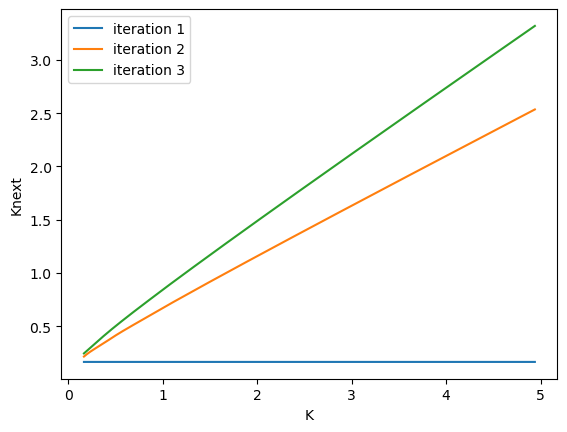

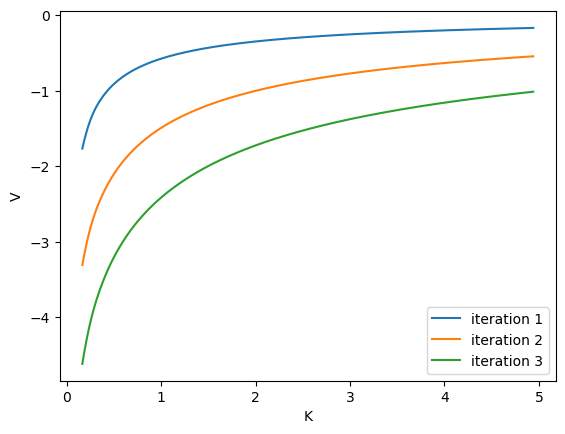

In [113]:
plt.plot(Kplot, Knextapprox1(Kplot), label = "iteration 1")
plt.plot(Kplot, Knextapprox2(Kplot), label = "iteration 2")
plt.plot(Kplot, Knextapprox3(Kplot), label = "iteration 3")
plt.xlabel("K")
plt.ylabel("Knext")
plt.legend()
plt.show()

plt.plot(Kplot, Vapprox1(Kplot), label = "iteration 1")
plt.plot(Kplot, Vapprox2(Kplot), label = "iteration 2")
plt.plot(Kplot, Vapprox3(Kplot), label = "iteration 3")
plt.xlabel("K")
plt.ylabel("V")
plt.legend()
plt.show()



Iterate until convergence
We know that we have only solved the Bellman equation, once the functions $V^{\text{old}}(\cdot)$ and $V^{\text{new}}(\cdot)$ are identical. Meaning the updated value function we get out is extremely close to the guess we put in on the right hand side of the Bellman equation. To do this, we keep updating the value function and the guess for the continuation value, until the difference between the two functions is below a threshold `tol` for all possible values of $K$.

In [125]:
def converge_Bellman(Kgrid, alpha, beta, delta, maxiter = 1000, tol = 1e-9, plotting = False):
    """
    Solves the Bellman equation for the Ramsey model using dyanmic programming.

    inputs:
    Kgrid:      vector of nK floats, giving the interpolation nodes
    alpha:      float, capital share in production, such that Y = K ^ alpha
    beta:       float, patience
    delta:      float, depreciation rate of capital
    maxiter:    int, maximum number of iterations
    tol:        float, threshold for convergence
    plotting:   bool, if True some intermediate figures will be plotted

    
    output:
    Vapprox:    value function V(K) 
    Knextapprox: policy function pi(K) 
    success:    bool, True if convergence was achieved.
    """

    
    nK = Kgrid.shape[0]
    

    # intialize value for the policy and value function we assume that the vlaue is 0 and the policy is to save the lowest level in our intveral
    Vgrid = np.zeros(nK)

    Vapprox = interp1d(Kgrid, Vgrid, kind = "cubic", fill_value="extrapolate")

    # get vector to plots
    Kplot = np.linspace(Kgrid[0], Kgrid[-1], 10000)
    
    for i in range(maxiter):
        # update the value and policy functions
        Vapprox_new, Knextapprox_new = update_V(Kgrid, Vapprox, alpha, beta, delta)
        
        if plotting:
            # we want to make some graphs in the first 7 iterations, and then every 50 steps
            if i % 50 == 0 or i < 7:

                plt.title("iteration " + str(i))
                plt.plot(Kplot, Vapprox_new(Kplot))
                plt.xlabel("K")
                plt.ylabel("V(K)")
                plt.show()

                plt.title("iteration " + str(i))
                plt.plot(Kplot, Knextapprox_new(Kplot), label = "Knext")
                plt.plot(Kplot, Kplot, label = "diagonal")
                plt.plot(Kss, Kss,  color = "k", marker = "o", label = "Kss")
                plt.legend()
                plt.show()

        # compute the maximum difference between the new and old value function
        # since, because of the discrete inputs, both functions are vectors, we compute the maximum difference between any
        # of the entries of the vectors.
        dif = np.max(np.abs(Vapprox_new(Kgrid) - Vapprox(Kgrid)))
        if i % 10 == 0:
            print("dif = ", dif)

        # we update our guess for the continuation value to the updated value function
        Vapprox = Vapprox_new

        # if the difference is below the tolerance, we found the solution       
        if dif < tol:
            print("Converged successfully!")
            success =  True

            return Vapprox_new, Knextapprox_new, success

    # if we want through the maximum number of iterations without converging
    # we did not succeed in solving the Bellman equation
    print("Not converged within ", maxiter, "iterations.")
    print("Maximum difference between new and old value function = ", dif)
    print("Required tolerance = ", tol)
    
    success =  False

    return Vapprox_new, Knextapprox_new, success


In [127]:
Vapprox, Knextapprox, success = converge_Bellman(Kgrid, alpha, beta, delta, maxiter = 10000, tol = 1e-8, plotting = False)

dif =  1.766393489967488
dif =  0.43497594876563106
dif =  0.14089450915097856
dif =  0.048380735928205354
dif =  0.01681234736104642
dif =  0.005857661063966901
dif =  0.0020420917002716976
dif =  0.0007120061246261855
dif =  0.0002482590458150469
dif =  8.6562408540658e-05
dif =  3.0182432340097876e-05
dif =  1.0523962380659668e-05
dif =  3.669478715551122e-06
dif =  1.2794681119032703e-06
dif =  4.4612295013735093e-07
dif =  1.5555345811435473e-07
dif =  5.423813931315635e-08
dif =  1.891167400458471e-08
Converged successfully!


Inspecting the result

Now we want to inspect the results. We can start out with plotting the final policy and value functions.

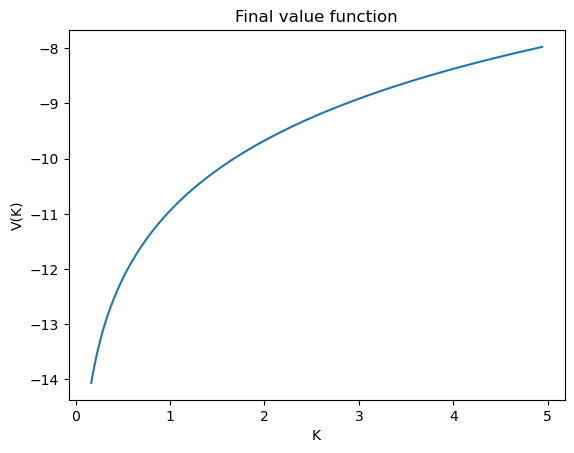

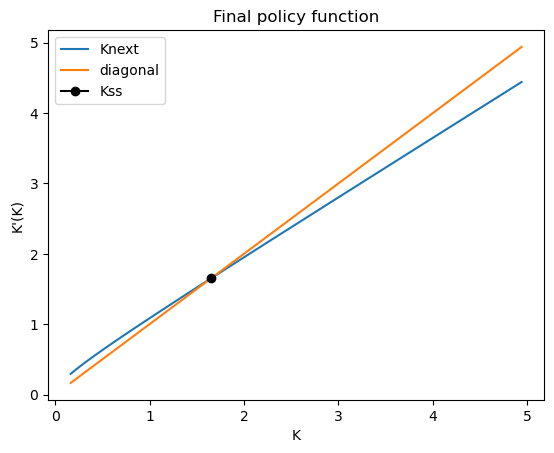

In [128]:
plt.title("Final value function")
plt.plot(Kplot, Vapprox(Kplot))
plt.xlabel("K")
plt.ylabel("V(K)")
plt.show()

plt.title("Final policy function")
plt.plot(Kplot, Knextapprox(Kplot), label = "Knext")
plt.plot(Kplot, Kplot, label = "diagonal")
plt.plot(Kss, Kss,  color = "k", marker = "o", label = "Kss")
plt.xlabel("K")
plt.ylabel("K'(K)")
plt.legend()
plt.show()



Next, we may want to sumulate the model.

In [129]:
def simulation(Kstart, Knextapprox, T, alpha = 0.3, delta = 0.1):
    # this function simulates the economy forward for T periods, starting from Kstart
    # given a policy Knextapprox

    # prepare empty array to store the quantities of interest for the T periods
    K_simulation = np.zeros(T)
    Y_simulation = np.zeros(T)
    I_simulation = np.zeros(T)
    C_simulation = np.zeros(T)

    # initialize the simulation with the starting value of capital
    K_simulation[0] = Kstart

    # simulate forward
    for t in range(T):
        # read out capital
        K = K_simulation[t]

        # compute the implied output
        Y = K ** alpha

        # get the policy for Knext
        Knext = Knextapprox(K)

        # compute the investment implied by K and Knext
        I = Knext - (1 - delta) * K

        # compute the implied consumption
        C = Y - I

        # store values
        K_simulation[t] = K
        Y_simulation[t] = Y
        I_simulation[t] = I
        C_simulation[t] = C

        if t < T - 1:
            # get the new state
            K_simulation[t+1] = Knext

    return K_simulation, Y_simulation, I_simulation, C_simulation

    

In [131]:
# simulate 50 periods, starting from low capital
Kstart0 = Kgrid[0]

T = 50

K_simulation_0, Y_simulation_0, I_simulation_0, C_simulation_0 = simulation(Kstart0, Knextapprox, T, alpha, delta)



In [132]:
# simulate 50 periods, starting from high capital
Kstart1 = Kgrid[-1]
T = 50

K_simulation_1, Y_simulation_1, I_simulation_1, C_simulation_1 = simulation(Kstart1, Knextapprox, T, alpha, delta)

In [133]:
# simulate 50 periods, starting from steady state capital (we should stay there)

Kstart2 = Kss
K_simulation_2, Y_simulation_2, I_simulation_2, C_simulation_2 = simulation(Kstart2, Knextapprox, T, alpha, delta)

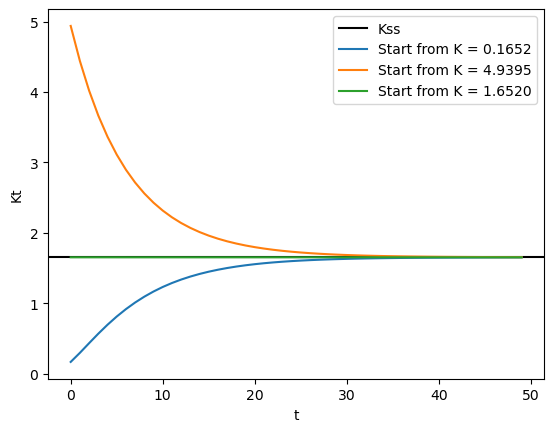

In [134]:
plt.axhline(Kss, color = "k", label = "Kss")
plt.plot(K_simulation_0, label = "Start from K = "+"{:.4f}".format(Kstart0))
plt.plot(K_simulation_1, label = "Start from K = "+"{:.4f}".format(Kstart1))
plt.plot(K_simulation_2, label = "Start from K = "+"{:.4f}".format(Kstart2))
plt.legend()
plt.xlabel("t")
plt.ylabel("Kt")
plt.show()

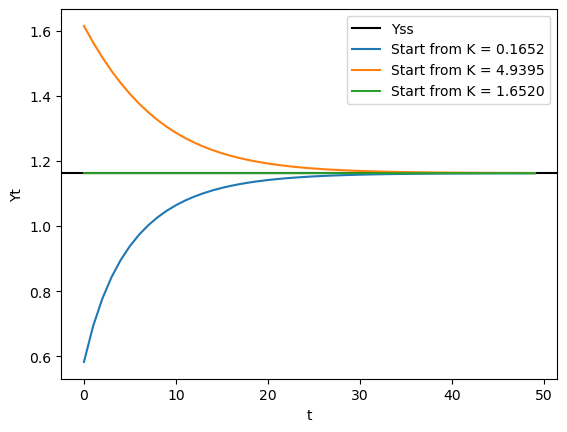

In [135]:
plt.axhline(Kss ** alpha, color = "k", label = "Yss")
plt.plot(Y_simulation_0, label = "Start from K = "+"{:.4f}".format(Kstart0))
plt.plot(Y_simulation_1, label = "Start from K = "+"{:.4f}".format(Kstart1))
plt.plot(Y_simulation_2, label = "Start from K = "+"{:.4f}".format(Kstart2))
plt.legend()
plt.xlabel("t")
plt.ylabel("Yt")
plt.show()

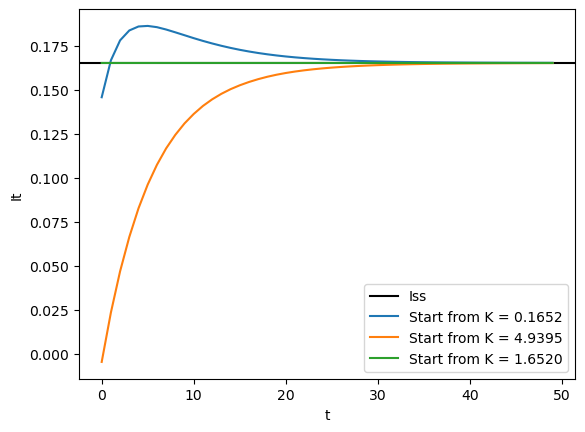

In [136]:
plt.axhline(delta * Kss, color = "k", label = "Iss")
plt.plot(I_simulation_0, label = "Start from K = "+"{:.4f}".format(Kstart0))
plt.plot(I_simulation_1, label = "Start from K = "+"{:.4f}".format(Kstart1))
plt.plot(I_simulation_2, label = "Start from K = "+"{:.4f}".format(Kstart2))
plt.legend()
plt.xlabel("t")
plt.ylabel("It")
plt.show()

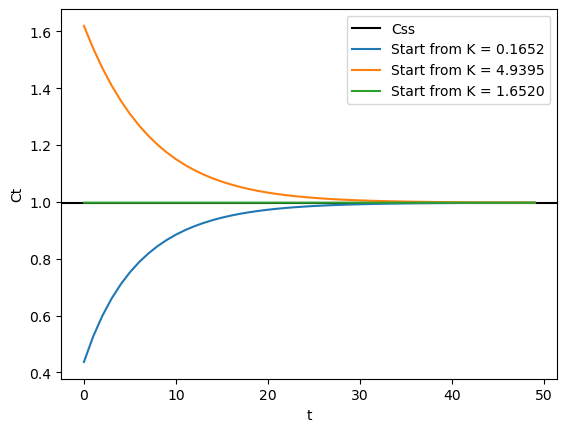

In [137]:
plt.axhline(Kss ** alpha - delta * Kss, color = "k", label = "Css")
plt.plot(C_simulation_0, label = "Start from K = "+"{:.4f}".format(Kstart0))
plt.plot(C_simulation_1, label = "Start from K = "+"{:.4f}".format(Kstart1))
plt.plot(C_simulation_2, label = "Start from K = "+"{:.4f}".format(Kstart2))
plt.legend()
plt.xlabel("t")
plt.ylabel("Ct")
plt.show()